# Цель

Разработать программу, которая с помощью ИИ и технологий обработки изображений от Mediapipe и OpenCV, будет анализировать ключевые точки тела человека, выполняющего упражнения, и оценивать правильность выполнения.

# Результаты выполнения проекта

Полученная программа в реальном времени выводит информацию о трех типах упражнения: становая тяга, присед, отжимания; позиции относительно горизонта: верх, низ; счет повторений упражнения. 

Также для каждого типа упражнения выводится информация о положении рук, ног и туловища.

Для отжиманий это положение бедер: высоко, нормально, низко; положение запястий: широко, нормально, узко.

Для отжиманий это положение ног: широко, узко, нормально.

Для становой тяги это положение рук: широко, узко, нормально; положение ног: широко, узко, нормально. 

Правильное положение частей тела подсвечивается зеленым, а неправильное красным.


Присед


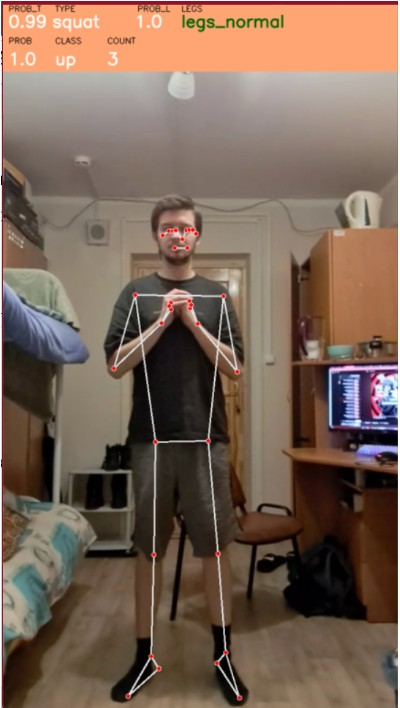

In [61]:
from IPython.display import Image
print("Присед")
Image(filename='squat.jpg', width=300)

Становая


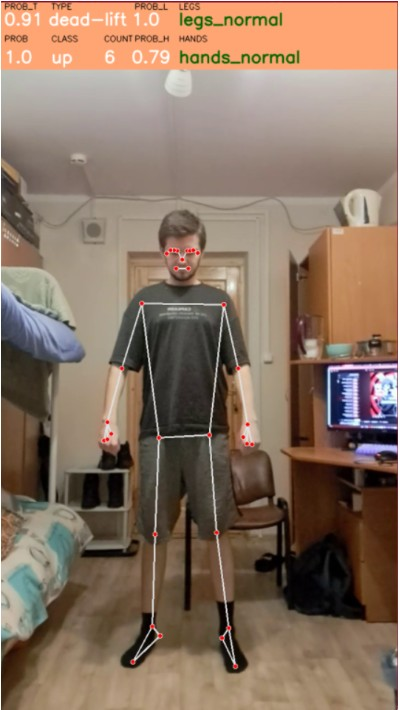

In [62]:
print("Становая")
Image(filename='deadlift_up.jpg', width=300)

Становая


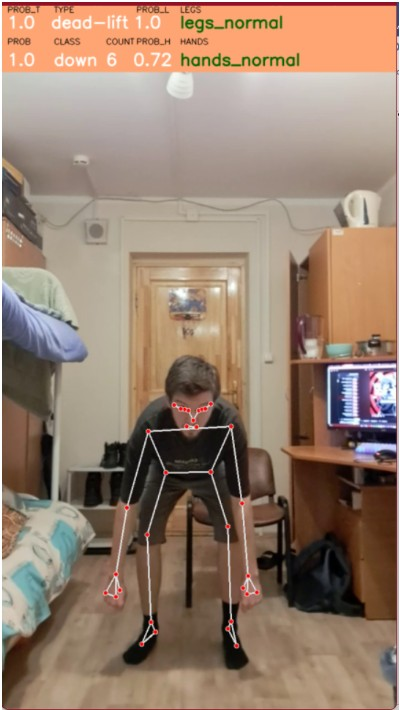

In [63]:
print("Становая")
Image(filename='deadlift_down.jpg', width=300)

Отжимание 1


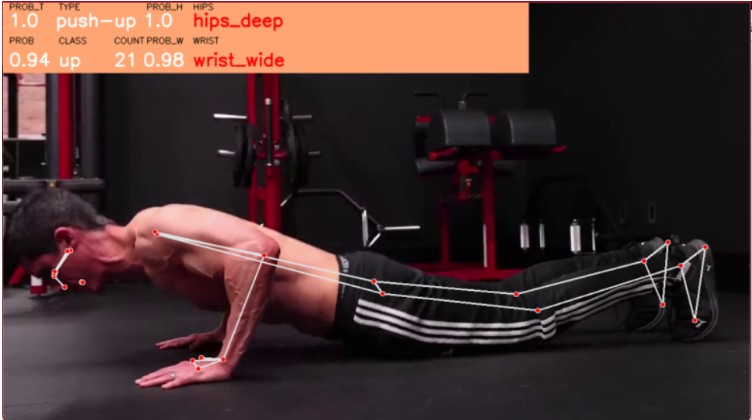

In [64]:
print("Отжимание 1")
Image(filename='pushup_1.jpg', width=600)

Отжимание 2


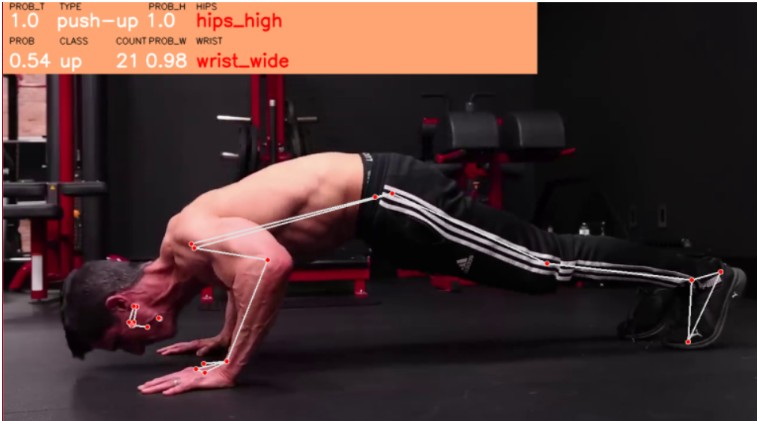

In [65]:
print("Отжимание 2")
Image(filename='pushup_2.jpg', width=600)

Программу можно использовать при записанном заранее видео или в режиме реального времени.

Эти данные выводятся на видео, и с помощью этого пользователь может корректировать свое положение, для достижения правильной техники. 

Данная программа позволяет выполнять базовые упражнения без специального тренера, хотя от тренеров не советую отказываться, т.к. программа не может заметить мелкие ошибки в технике, однако базовые ошибки она видит.


# Создание датасета

Для получения ключевых точек человека и дальнейшей работы с ними был использован фреймворк MediaPipe. Он использует 33 ключевые точки с координатами x, y, z и v. Где v – видимость точки.

### Отслеживание позиции

Для получения ключевых точек человека и дальнейшей работы с ними был использован фреймворк MediaPipe. Он использует 33 ключевые точки с координатами x, y, z и v. Где v – видимость точки. 

In [ ]:
import mediapipe as mp
import cv2
import numpy as np

Для визуализации и отслеживания координат приведен следующий код:

In [2]:
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

### Захват точек и экспорт в csv

In [3]:
import csv
import os
import numpy as np
from matplotlib import pyplot as plt

Создание csv файла с обозначенными колонками

In [4]:
landmarks = ['type','class', 'stand']
for val in range(1, 33+1):
    landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'v{}'.format(val)]

In [ ]:
with open('Data/Deadlift/deadlift.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerow(landmarks)


Для сохранения точек, положения тела относительно камеры и положения тела была определена функция:

In [6]:
def export_landmark(results, action, stand):
    try:
        keypoints = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten().tolist()
        keypoints.insert(0, action)
        keypoints.insert(1, stand)

        with open('Data/Deadlift/deadlift.csv', mode='a', newline='') as f:
            csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csv_writer.writerow(keypoints)
    except Exception as e:
        pass

Для визуализации данных была использована библиотека OpenCV. 

Способ сохранения ключевых точек заключается в том, что проигрывается видео из которого мы хотим получить ключевые точки, и в нужный момент времени нажимаются заранее определенные кнопки. С помощью этого в csv файл переносятся положения ключевых точек и состояние, в котором находится тело.

Например на видео показывается упражнение «Становая тяга». Человек стоит к камере лицом в положении, когда он поднял штангу, нажимая кнопку «w» в датасет сохраняется следующая информация: тип упражнения – становая тяга, позиция тела относительно камеры – фронтальная, позиция тела относительно горизонтальной линии – верх, ключевые точки в данный момент. 


In [ ]:
cap = cv2.VideoCapture("Data/Deadlift/Deadlift3.mp4")
with mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.7) as pose:
    #Зацикливание видео
    while cap.isOpened():
        ret, frame = cap.read()
        
        #Конвертация в RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        #Предсказывание 
        results = pose.process(image)

        #Конвертация в BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        #Отрисовка предсказаний
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        k = cv2.waitKey(1)

        if k == ord("w"):
            export_landmark(results,"front", "up")
            cv2.putText(image, "UP", (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), cv2.LINE_AA)
        if k == ord("s"):
            export_landmark(results,"front", "down")
            cv2.putText(image, "DOWN", (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), cv2.LINE_AA)
        if k == ord("e"):
            export_landmark(results,"side", "up")
            cv2.putText(image, "UP", (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), cv2.LINE_AA)
        if k == ord("d"):
            export_landmark(results,"side", "down")
            cv2.putText(image, "DOWN", (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), cv2.LINE_AA)
        if k == ord("r"):
            export_landmark(results,"half-side", "up")
            cv2.putText(image, "UP", (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), cv2.LINE_AA)
        if k == ord("f"):
            export_landmark(results,"half-side", "down")
            cv2.putText(image, "DOWN", (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), cv2.LINE_AA)
        #Рамка с информацией
        cv2.imshow("Mediapipe Feed", image)

        #Break
        if cv2.waitKey(10) & 0xFF == ord("q"):
            break
        
#Закрытие окна 
cap.release()
cv2.destroyAllWindows()

### Подготовка данных

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [8]:
df = pd.read_csv('train.csv')
df_legs = pd.read_csv('legs.csv')
df_hands_deadlift = pd.read_csv('hands_deadlift.csv')
df_wrist = pd.read_csv('wrist.csv')
df_hips = pd.read_csv('hips.csv')

In [9]:
df.head()

,type,class,stand,x1,y1,z1,v1,x2,y2,z2,...,z31,v31,x32,y32,z32,v32,x33,y33,z33,v33
0,dead-lift,front,down,0.681680,0.495476,-0.665857,0.999982,0.688466,0.477538,-0.649423,...,-0.067771,0.876991,0.738542,0.967861,-0.236746,0.952682,0.629684,0.962561,-0.223977,0.970226
1,dead-lift,front,up,0.689298,0.158959,-0.328866,0.999988,0.696061,0.138726,-0.315265,...,0.185979,0.892583,0.737007,0.965222,0.057636,0.983949,0.634892,0.962945,0.062778,0.982171
2,dead-lift,front,down,0.687187,0.493779,-0.612641,0.999982,0.693403,0.476564,-0.599650,...,-0.084815,0.806804,0.736935,0.967913,-0.228807,0.938333,0.627986,0.959556,-0.226172,0.951194
3,dead-lift,front,up,0.687917,0.157955,-0.328776,0.999988,0.695031,0.136730,-0.315176,...,0.211188,0.895865,0.734261,0.965009,0.075533,0.984826,0.634537,0.963924,0.092182,0.982049
4,dead-lift,front,down,0.691109,0.485394,-0.609468,0.999977,0.696950,0.467533,-0.596517,...,-0.075773,0.793415,0.739945,0.965006,-0.226144,0.927069,0.627123,0.960708,-0.215247,0.947154


In [176]:
df_wrist.head()

,wrist,x1,y1,z1,v1,x2,y2,z2,v2,x3,...,z31,v31,x32,y32,z32,v32,x33,y33,z33,v33
0,wrist_normal,0.536363,0.321668,-1.005728,0.999996,0.512068,0.338242,-1.089108,0.999994,0.569833,...,1.131809,0.153467,0.586935,0.684509,1.048572,0.578679,0.435995,0.694471,1.010670,0.525491
1,wrist_normal,0.523650,0.320587,-1.965678,0.999884,0.509746,0.326224,-2.030590,0.999863,0.568792,...,1.508991,0.099470,0.624571,0.688379,1.328689,0.372387,0.451616,0.703161,1.346171,0.338608
2,wrist_normal,0.550625,0.315715,-1.996865,0.999919,0.547086,0.294818,-2.075863,0.999898,0.608394,...,1.690322,0.170657,0.635770,0.702435,1.543712,0.472243,0.447034,0.702448,1.492967,0.447811
3,wrist_narrow,0.502440,0.307271,-2.079183,0.999945,0.524058,0.281836,-2.135974,0.999930,0.549235,...,1.374258,0.332090,0.622821,0.710305,1.162860,0.641939,0.429440,0.716117,1.154115,0.722692
4,wrist_narrow,0.502039,0.309996,-2.178964,0.999922,0.524904,0.282919,-2.240952,0.999903,0.552283,...,1.740686,0.260939,0.608311,0.683859,1.602360,0.599697,0.446630,0.696686,1.517575,0.648656


In [19]:
df[df['type']=='push-up']

,type,class,stand,x1,y1,z1,v1,x2,y2,z2,...,z31,v31,x32,y32,z32,v32,x33,y33,z33,v33
893,push-up,half-side,down,0.132020,0.916188,-0.525242,0.999773,0.133564,0.882098,-0.547769,...,0.775317,0.488495,0.696697,0.849279,0.599133,0.739526,0.655873,0.801853,0.803047,0.468901
894,push-up,half-side,down,0.136561,0.916897,-0.523978,0.999763,0.138759,0.881871,-0.546273,...,0.741855,0.486610,0.700117,0.849542,0.579151,0.724183,0.662536,0.811650,0.768880,0.449878
895,push-up,half-side,up,0.200038,0.285415,-0.556678,0.999825,0.209043,0.250292,-0.565583,...,0.734427,0.373676,0.706652,0.839849,0.468063,0.822776,0.687575,0.838300,0.697410,0.598020
896,push-up,half-side,up,0.213858,0.300144,-0.615442,0.999860,0.219995,0.261102,-0.627302,...,0.772269,0.426506,0.706803,0.844049,0.489028,0.847058,0.691246,0.844793,0.734486,0.655859
897,push-up,half-side,down,0.209238,0.921836,-0.529910,0.999692,0.215548,0.887045,-0.552722,...,0.747199,0.416978,0.750042,0.859573,0.570203,0.733555,0.691485,0.812519,0.785823,0.408551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204,push-up,front,up,0.502149,0.323201,-0.709763,0.999965,0.520474,0.283740,-0.703129,...,0.772462,0.043811,0.508565,0.682245,0.719610,0.189725,0.481782,0.684046,0.708393,0.178483
1205,push-up,front,up,0.501928,0.325075,-0.709736,0.999973,0.520901,0.286399,-0.703820,...,0.771531,0.044035,0.509137,0.682708,0.715330,0.198638,0.482329,0.686150,0.707233,0.185132
1206,push-up,front,down,0.477559,0.982456,-0.448347,0.999870,0.488461,0.975786,-0.491287,...,0.805397,0.079098,0.554456,0.641469,0.795213,0.045276,0.496331,0.642290,0.817132,0.043294
1207,push-up,front,down,0.476633,0.991799,-0.389784,0.999901,0.488275,0.982308,-0.432453,...,0.823679,0.104683,0.550942,0.641206,0.819886,0.034601,0.498656,0.635469,0.836918,0.032341


# Разделение данных для обучения

### Данные для определения типа упражнения

Для входной величины выбираются значения ключевых точек, для выходной – значения позиции, соответствующее этим ключевым точкам.

In [9]:
X = df.drop(['type', 'class', 'stand'], axis=1)
y= df['stand']
y_type = df['type']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
X_train, X_test, y_type_train, y_type_test = train_test_split(X, y_type, test_size=0.3, random_state=12)

In [42]:
X_train.shape

(1084, 132)

In [64]:
X_test

,x1,y1,z1,v1,x2,y2,z2,v2,x3,y3,...,z31,v31,x32,y32,z32,v32,x33,y33,z33,v33
1402,0.238166,0.420027,-0.725038,0.999971,0.247976,0.410746,-0.725682,0.999932,0.252529,0.410595,...,0.160173,0.833077,0.366817,0.680773,-0.527163,0.978782,0.230308,0.664369,0.077724,0.871108
10,0.757580,0.125352,-0.113073,0.916418,0.752767,0.105081,-0.100358,0.893378,0.751607,0.104386,...,0.154563,0.654102,0.762904,0.860899,0.185290,0.632533,0.783410,0.832322,0.085453,0.770447
811,0.641297,0.598161,-0.127248,0.999895,0.639950,0.587720,-0.114932,0.999841,0.640073,0.587601,...,-0.149192,0.980945,0.621471,0.836641,0.086563,0.961148,0.587668,0.869157,-0.176950,0.995885
871,0.640832,0.604994,-0.032938,0.999242,0.640333,0.594968,-0.023285,0.999149,0.640288,0.594411,...,-0.077795,0.992857,0.612651,0.826148,0.215138,0.826762,0.607278,0.861288,-0.097375,0.994846
719,0.675578,0.597452,-0.062456,0.999714,0.676184,0.584903,-0.052877,0.999556,0.675986,0.584267,...,-0.109157,0.991214,0.651714,0.853724,0.134731,0.902407,0.625778,0.885536,-0.131443,0.994271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,0.464184,0.423966,-0.033548,0.996185,0.467355,0.414356,-0.047172,0.996559,0.468813,0.414121,...,0.385633,0.457232,0.490817,0.796253,-0.184322,0.823542,0.491008,0.759012,0.410629,0.465795
1405,0.234428,0.422680,-0.760322,0.999975,0.244676,0.412349,-0.759177,0.999942,0.249249,0.412027,...,0.159419,0.839882,0.366503,0.680583,-0.522752,0.977258,0.233007,0.665109,0.073812,0.869146
1159,0.137303,0.725493,0.034341,0.999111,0.131231,0.701057,0.008255,0.998935,0.132441,0.697736,...,0.069261,0.532203,0.833103,0.723247,-0.185360,0.940169,0.814810,0.703555,0.003886,0.577095
952,0.087106,0.893477,-0.001211,0.998649,0.076041,0.866436,-0.029563,0.998321,0.076431,0.863172,...,0.155384,0.625827,0.857551,0.860513,-0.152790,0.972254,0.839532,0.848520,0.080978,0.721820


In [80]:
y_train.shape

(1084,)

In [81]:
y_type_test

1402    dead-lift
10      dead-lift
811         squat
871         squat
719         squat
          ...    
167         squat
1405    dead-lift
1159      push-up
952       push-up
1383    dead-lift
Name: type, Length: 465, dtype: object

### Данные для оценки правильности упражнений

Ноги

In [11]:
X_legs = df_legs.drop(['legs'], axis=1)
y_legs = df_legs['legs']

In [12]:
X_train_legs, X_test_legs, y_train_legs, y_test_legs = train_test_split(X_legs, y_legs, test_size=0.3, random_state=3)

Руки для становой

In [13]:
X_hands_deadlift = df_hands_deadlift.drop(['hands_deadlift'], axis=1)
y_hands_deadlift = df_hands_deadlift['hands_deadlift']

In [14]:
X_train_hands_deadlift, X_test_hands_deadlift, y_train_hands_deadlift, y_test_hands_deadlift = train_test_split(X_hands_deadlift, y_hands_deadlift, test_size=0.3, random_state=12)

Запястья для отжиманий

In [15]:
X_wrist = df_wrist.drop(['wrist'], axis=1)
y_wrist = df_wrist['wrist']

In [16]:
X_train_wrist, X_test_wrist, y_train_wrist, y_test_wrist = train_test_split(X_wrist, y_wrist, test_size=0.3, random_state=12)

Положение бедер для отжиманий

In [17]:
X_hips = df_hips.drop(['hips'], axis=1)
y_hips = df_hips['hips']

In [18]:
X_train_hips, X_test_hips, y_train_hips, y_test_hips = train_test_split(X_hips, y_hips, test_size=0.3, random_state=12)

# Обучение классификационной модели 

In [19]:
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import CountVectorizer

Конвейеры с моделями

In [20]:
pipelines = {
    'lr':make_pipeline(StandardScaler(), LogisticRegression()),
    'rc':make_pipeline(StandardScaler(), RidgeClassifier()),
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
}
pipelines1 = {
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
}
pipelines2 = {
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
}
pipelines3 = {
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
}
pipelines4 = {
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
}
pipelines5 = {
    'rf':make_pipeline(StandardScaler(), RandomForestClassifier()),
    'gb':make_pipeline(StandardScaler(), GradientBoostingClassifier()),
}

Наполнение конвейеров тренировочными данными

In [ ]:
# Модель для определения положения тела
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model

# Модель для определения типа упражнения
fit_models_type = {}
for algo, pipeline in pipelines1.items():
    model_type = pipeline.fit(X_train, y_type_train)
    fit_models_type[algo] = model_type

In [ ]:
# Модель для определения положения ног
fit_models_legs = {}
for algo, pipeline in pipelines2.items():
    model_legs = pipeline.fit(X_train_legs, y_train_legs)
    fit_models_legs[algo] = model_legs

In [ ]:
# Модель для определения положения рук для становой
fit_models_hands_deadlift = {}
for algo, pipeline in pipelines3.items():
    model_hands_deadlift = pipeline.fit(X_train_hands_deadlift, y_train_hands_deadlift)
    fit_models_hands_deadlift[algo] = model_hands_deadlift

In [ ]:
# Модель для определения положения запястий для отжиманий
fit_models_wrist = {}
for algo, pipeline in pipelines4.items():
    model_wrist = pipeline.fit(X_train_wrist, y_train_wrist)
    fit_models_wrist[algo] = model_wrist

In [ ]:
# Модель для определения положения таза для отжиманий
fit_models_hips = {}
for algo, pipeline in pipelines5.items():
    model_hips = pipeline.fit(X_train_hips, y_train_hips)
    fit_models_hips[algo] = model_hips

In [55]:
model1 = Pipeline(steps=[('cv', CountVectorizer(lowercase=False)), ('lr_multi', MultiOutputClassifier(LogisticRegression()))])

In [56]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

### Проверка моделей

Для оценки точности моделей используется accuracy, precision и recall

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import pickle

Модель для определения положения тела

In [27]:
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print(algo, accuracy_score(y_test.values, yhat),
         precision_score(y_test.values, yhat, average="binary", pos_label="up"),
         recall_score(y_test.values, yhat, average="binary", pos_label="up"))

lr 0.9978494623655914 0.9945652173913043 1.0
rc 0.9978494623655914 0.9945652173913043 1.0
rf 0.9935483870967742 0.9891304347826086 0.994535519125683
gb 0.9870967741935484 0.9682539682539683 1.0


Модель для определения типа упражнения

In [28]:
for algo, model_type in fit_models_type.items():
    yhat = model_type.predict(X_test)
    print(algo, accuracy_score(y_type_test.values, yhat),
         precision_score(y_type_test.values, yhat, average="weighted"),
         recall_score(y_type_test.values, yhat, average="weighted"))

rf 0.9913978494623656 0.991500482017056 0.9913978494623656
gb 0.9935483870967742 0.9937138130686518 0.9935483870967742


Модель для определения положения ног

In [29]:
for algo, model_legs in fit_models_legs.items():
    yhat = model_legs.predict(X_test_legs)
    print(algo, accuracy_score(y_test_legs.values, yhat),
         precision_score(y_test_legs.values, yhat, average="weighted"),
         recall_score(y_test_legs.values, yhat, average="weighted"))

rf 1.0 1.0 1.0
gb 0.9813084112149533 0.9825545171339564 0.9813084112149533


Модель для определения положения рук для становой

In [30]:
for algo, model_hands_deadlift in fit_models_hands_deadlift.items():
    yhat = model_hands_deadlift.predict(X_test_hands_deadlift)
    print(algo, accuracy_score(y_test_hands_deadlift.values, yhat),
         precision_score(y_test_hands_deadlift.values, yhat, average="weighted"),
         recall_score(y_test_hands_deadlift.values, yhat, average="weighted"))

rf 1.0 1.0 1.0
gb 1.0 1.0 1.0


Модель для определения положения запястий для отжиманий

In [31]:
for algo, model_wrist in fit_models_wrist.items():
    yhat = model_wrist.predict(X_test_wrist)
    print(algo, accuracy_score(y_test_wrist.values, yhat),
         precision_score(y_test_wrist.values, yhat, average="weighted"),
         recall_score(y_test_wrist.values, yhat, average="weighted"))

rf 1.0 1.0 1.0
gb 1.0 1.0 1.0


Модель для определения положения таза для отжиманий

In [32]:
for algo, model_hips in fit_models_hips.items():
    yhat = model_hips.predict(X_test_hips)
    print(algo, accuracy_score(y_test_hips.values, yhat),
         precision_score(y_test_hips.values, yhat, average="weighted"),
         recall_score(y_test_hips.values, yhat, average="weighted"))

rf 0.96 0.9608602150537634 0.96
gb 0.9466666666666667 0.9491666666666667 0.9466666666666667


### Сохранение моделей

In [33]:
with open('Data/Deadlift/deadlift.pkl', 'wb') as f:
    pickle.dump(fit_models['lr'], f)

In [34]:
with open('type.pkl', 'wb') as f1:
    pickle.dump(fit_models_type['gb'], f1)

In [35]:
with open('legs.pkl', 'wb') as f2:
    pickle.dump(fit_models_legs['gb'], f2)

In [36]:
with open('hands_deadlift.pkl', 'wb') as f3:
    pickle.dump(fit_models_hands_deadlift['gb'], f3)

In [37]:
with open('wrist.pkl', 'wb') as f4:
    pickle.dump(fit_models_hands_deadlift['gb'], f4)

In [38]:
with open('hips.pkl', 'wb') as f5:
    pickle.dump(fit_models_hands_deadlift['rf'], f5)

# Тестирование моделей

### Импорт моделей

In [39]:
with open('Data/Deadlift/deadlift.pkl', 'rb') as f:
    model = pickle.load(f)

In [40]:
with open('type.pkl', 'rb') as f1:
    model_type = pickle.load(f1)

In [41]:
with open('legs.pkl', 'rb') as f2:
    model_legs = pickle.load(f2)

In [42]:
with open('hands_deadlift.pkl', 'rb') as f3:
    model_hands_deadlift = pickle.load(f3)

In [43]:
with open('wrist.pkl', 'rb') as f4:
    model_hands_deadlift = pickle.load(f4)

In [44]:
with open('hips.pkl', 'rb') as f5:
    model_hands_deadlift = pickle.load(f5)

In [ ]:
def rescale_frame(frame, scale):
    width = int(frame.shape[1] * scale)
    height = int(frame.shape[0] * scale)
    dimensions = (width, height)
    return cv2.resize(frame, dimensions, interpolation=cv2.INTER_AREA)

### Основная программа

In [ ]:
path_vid = 0
cap = cv2.VideoCapture(path_vid)
cap.set(3, 1440)
counter = 0
current_stage = ''
with mp_pose.Pose(min_detection_confidence=0.7, min_tracking_confidence=0.7) as pose:
    #Зацикливание видео
    while cap.isOpened():
        ret, frame = cap.read()
        
        #Конвертация в RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        #Предсказывание
        results = pose.process(image)

        #Конвертация в BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        #Отрисовка предсказаний
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        try:
            #Данные для типа упражнения и стадии
            row = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten().tolist()
            X = pd.DataFrame([row], columns=landmarks[3:])
            #Тип упражнения
            train_type = model_type.predict(X)[0]
            train_type_prob = model_type.predict_proba(X)[0]
            print(train_type, train_type_prob)
            #Класс позиции (up/down)
            body_language_class = model.predict(X)[0]
            body_language_prob = model.predict_proba(X)[0]
            print(body_language_class, body_language_prob)

            #Данные для ног [deadlift&squats]
            train_legs = model_legs.predict(X)[0]
            train_legs_prob = model_legs.predict_proba(X)[0]
            print(train_legs, train_legs_prob)

            #Данные для рук [deadlift]
            train_hands_deadlift = model_hands_deadlift.predict(X)[0]
            train_hands_deadlift_prob = model_hands_deadlift.predict_proba(X)[0]
            print(train_hands_deadlift, train_hands_deadlift_prob)

            #Данные для запястий [push-up]
            train_wrist = model_wrist.predict(X)[0]
            train_wrist_prob = model_wrist.predict_proba(X)[0]
            print(train_wrist, train_wrist_prob)

            #Данные для бедер [push-up]
            train_hips = model_hips.predict(X)[0]
            train_hips_prob = model_hips.predict_proba(X)[0]
            print(train_hips, train_hips_prob)
            
            cv2.rectangle(image, (0,0), (550, 120), (115, 165, 255), -1)
            
            match train_type:
                case 'dead-lift' if train_type_prob[train_type_prob.argmax()] >= .6:
                    #Показ позиции рук для становой [deadlift]
                    cv2.putText(image, "HANDS", (325,70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                    #Изменение цвета
                    if train_hands_deadlift == 'hands_normal':
                        cv2.putText(image, train_hands_deadlift.split(' ')[0], (325,108), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 100, 0), 2, cv2.LINE_AA)
                    else:
                        cv2.putText(image, train_hands_deadlift.split(' ')[0], (325,108), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                        
                    cv2.putText(image, "PROB_H", (245,70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                    cv2.putText(image, str(round(train_hands_deadlift_prob[np.argmax(train_hands_deadlift_prob)],2)), (240,108), cv2.FONT_HERSHEY_SIMPLEX, 
                                1, (255, 255, 255), 2, cv2.LINE_AA)
                    
                    #Показ позиции ног
                    cv2.putText(image, "LEGS", (325,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                    #Изменение цвета
                    if train_legs == 'legs_normal':    
                        cv2.putText(image, train_legs.split(' ')[0], (325,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 100, 0), 2, cv2.LINE_AA)
                    else:
                        cv2.putText(image, train_legs.split(' ')[0], (325,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                        
                    cv2.putText(image, "PROB_L", (245,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                    cv2.putText(image, str(round(train_legs_prob[np.argmax(train_legs_prob)],2)), (240,40), cv2.FONT_HERSHEY_SIMPLEX, 
                                1, (255, 255, 255), 2, cv2.LINE_AA)
                    
                    #Счетчик
                    if body_language_class == 'down' and body_language_prob[body_language_prob.argmax()] >= .7:
                        current_stage = 'down'
                    elif current_stage == 'down' and body_language_class == 'up' and body_language_prob[body_language_prob.argmax()] >= .7:
                        current_stage = 'up'
                        counter += 1
                        
                case 'squat' if train_type_prob[train_type_prob.argmax()] >= .6:
                    #Показ позиции ног
                    cv2.putText(image, "LEGS", (325,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                    #Изменение цвета
                    if train_legs == 'legs_normal':    
                        cv2.putText(image, train_legs.split(' ')[0], (325,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 100, 0), 2, cv2.LINE_AA)
                    else:
                        cv2.putText(image, train_legs.split(' ')[0], (325,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

                    cv2.putText(image, "PROB_L", (245,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                    cv2.putText(image, str(round(train_legs_prob[np.argmax(train_legs_prob)],2)), (240,40), cv2.FONT_HERSHEY_SIMPLEX, 
                                1, (255, 255, 255), 2, cv2.LINE_AA)
                    
                    #Счетчик
                    if body_language_class == 'down' and body_language_prob[body_language_prob.argmax()] >= .7:
                        current_stage = 'down'
                    elif current_stage == 'down' and body_language_class == 'up' and body_language_prob[body_language_prob.argmax()] >= .7:
                        current_stage = 'up'
                        counter += 1
                        
                case 'push-up' if train_type_prob[train_type_prob.argmax()] >= .6:
                    #Показ позиции запястий
                    cv2.putText(image, "WRIST", (325,70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                    #Изменение цвета
                    if train_wrist == 'wrist_normal':
                        cv2.putText(image, train_wrist.split(' ')[0], (325,108), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 100, 0), 2, cv2.LINE_AA)
                    else:
                        cv2.putText(image, train_wrist.split(' ')[0], (325,108), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                        
                    cv2.putText(image, "PROB_W", (245,70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                    cv2.putText(image, str(round(train_wrist_prob[np.argmax(train_wrist_prob)],2)), (240,108), cv2.FONT_HERSHEY_SIMPLEX, 
                                1, (255, 255, 255), 2, cv2.LINE_AA)

                    #Показ позиции бедер
                    cv2.putText(image, "HIPS", (325,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                    #Изменение цвета
                    if train_hips == 'hips_normal':    
                        cv2.putText(image, train_hips.split(' ')[0], (325,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 100, 0), 2, cv2.LINE_AA)
                    else:
                        cv2.putText(image, train_hips.split(' ')[0], (325,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                        
                    cv2.putText(image, "PROB_H", (245,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                    cv2.putText(image, str(round(train_hips_prob[np.argmax(train_hips_prob)],2)), (240,40), cv2.FONT_HERSHEY_SIMPLEX, 
                                1, (255, 255, 255), 2, cv2.LINE_AA)
                    
                    #Счетчик
                    if body_language_class == 'down' and body_language_prob[body_language_prob.argmax()] >= .7:
                        current_stage = 'down'
                    elif current_stage == 'down' and body_language_class == 'up' and body_language_prob[body_language_prob.argmax()] >= .7:
                        current_stage = 'up'
                        counter += 1
            
            #Показ типа упражнения
            cv2.putText(image, "TYPE", (95,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, train_type.split(' ')[0], (90,40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            cv2.putText(image, "PROB_T", (10,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, str(round(train_type_prob[np.argmax(train_type_prob)],2)), (10,40), cv2.FONT_HERSHEY_SIMPLEX, 
                        1, (255, 255, 255), 2, cv2.LINE_AA)
            
            #Показ стадии up/down
            cv2.putText(image, "CLASS", (95,70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, body_language_class.split(' ')[0], (95,108), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

            cv2.putText(image, "PROB", (10,70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, str(round(body_language_prob[np.argmax(body_language_prob)],2)), (10,108), cv2.FONT_HERSHEY_SIMPLEX, 
                        1, (255, 255, 255), 2, cv2.LINE_AA)

            cv2.putText(image, "COUNT", (190,70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
            cv2.putText(image, str(counter), (190,108), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
        except Exception as e:
            pass
            
        #Рамка с информацией
        image_resized = rescale_frame(image, scale=.6)
        cv2.imshow("Mediapipe Feed", image_resized)

        #Break
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
#Закрытие окна  
cap.release()
cv2.destroyAllWindows()